Starting ETL process...
Generating 1000 synthetic retail records
Synthetic data generated with 1000 records
Starting data transformation
Data transformed. 483 records remaining after transformations
Database schema created (tables dropped and recreated)
Loaded 85 unique records into ProductDim
Loaded 100 unique records into CustomerDim
Loaded 264 unique records into TimeDim
Loaded 483 records into SalesFact with valid foreign keys
ETL process completed successfully

Running OLAP analysis...

=== OLAP ANALYSIS RESULTS ===

1. Roll-up: Sales by Country and Quarter:
      country  quarter  year  total_sales
0   Australia        3  2024     78664.44
1   Australia        4  2024    125194.01
2   Australia        1  2025     84318.46
3   Australia        2  2025     72897.95
4   Australia        3  2025     45301.44
5      Canada        3  2024     19457.55
6      Canada        4  2024     83234.59
7      Canada        1  2025     89314.72
8      Canada        2  2025     46359.70
9      Can

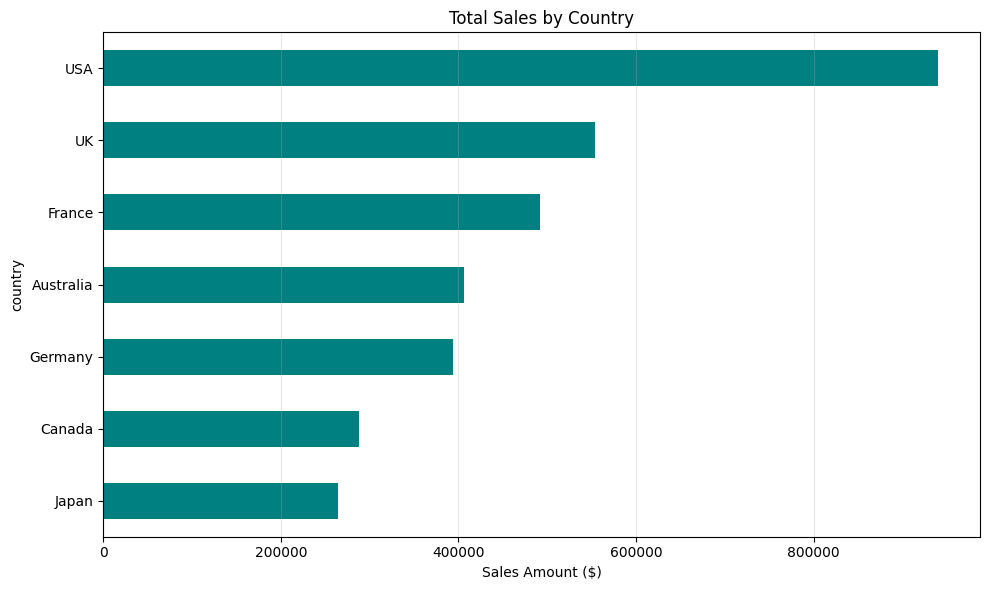


Saved visualization as 'sales_by_country.png'

Generated analysis report: olap_analysis_report.md


In [1]:
# COMPLETE RETAIL DATA WAREHOUSE SOLUTION

# ============ IMPORTS ============
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import logging
import random
import matplotlib.pyplot as plt

# ============ ETL CLASS ============
class RetailETL:
    def __init__(self):
        self.db_file = 'retail_dw.db'
        self.current_date = datetime(2025, 8, 12)  # As per exam instructions
        
        # Data generation components
        self.first_names = ['John', 'Jane', 'Robert', 'Emily', 'Michael', 'Sarah', 'David', 'Lisa']
        self.last_names = ['Smith', 'Johnson', 'Williams', 'Brown', 'Jones', 'Miller', 'Davis']
        self.cities = ['New York', 'London', 'Berlin', 'Paris', 'Tokyo', 'Sydney', 'Toronto']
        self.companies = ['TechCorp', 'GlobalMart', 'HomeGoods', 'FashionCo', 'ElectroWorld']
        
    def generate_name(self):
        return f"{random.choice(self.first_names)} {random.choice(self.last_names)}"
    
    def generate_synthetic_data(self, num_records=1000):
        """Generate synthetic retail data"""
        print(f"Generating {num_records} synthetic retail records")
        
        # Product categories and subcategories
        categories = {
            'Electronics': ['Smartphones', 'Laptops', 'Tablets', 'Accessories'],
            'Clothing': ['Men', 'Women', 'Kids', 'Accessories'],
            'Home': ['Furniture', 'Decor', 'Kitchen'],
            'Books': ['Fiction', 'Non-Fiction', 'Educational'],
            'Sports': ['Equipment', 'Apparel', 'Footwear']
        }
        
        # Generate products
        products = []
        product_id = 1
        for cat, subcats in categories.items():
            for subcat in subcats:
                for _ in range(5):  # 5 products per subcategory
                    products.append({
                        'product_id': product_id,
                        'name': f"{cat[:3]}-{subcat[:3]}-{product_id:03d}",
                        'category': cat,
                        'subcategory': subcat,
                        'supplier': random.choice(self.companies),
                        'current_price': round(random.uniform(10, 500), 2)
                    })
                    product_id += 1
        
        # Generate customers
        customers = []
        countries = ['UK', 'USA', 'Germany', 'France', 'Australia', 'Japan', 'Canada']
        for customer_id in range(1, 101):  # 100 unique customers
            customers.append({
                'customer_id': customer_id,
                'name': self.generate_name(),
                'location': random.choice(self.cities),
                'country': random.choice(countries),
                'demographic_segment': random.choice(['Young', 'Adult', 'Senior', 'Student']),
                'registration_date': (self.current_date - timedelta(days=random.randint(365, 1095))).strftime('%Y-%m-%d')
            })
        
        # Generate sales transactions
        data = []
        for _ in range(num_records):
            product = random.choice(products)
            customer = random.choice(customers)
            
            days_ago = random.randint(1, 730)
            date = (self.current_date - timedelta(days=days_ago)).strftime('%Y-%m-%d')
            
            quantity = random.randint(1, 50)
            unit_price = product['current_price'] * random.uniform(0.8, 1.2)
            total_sales = quantity * unit_price
            
            data.append({
                'InvoiceNo': f"INV{random.randint(1000, 9999)}",
                'StockCode': f"SKU{product['product_id']:04d}",
                'Description': product['name'],
                'Quantity': quantity,
                'InvoiceDate': date,
                'UnitPrice': round(unit_price, 2),
                'CustomerID': customer['customer_id'],
                'Country': customer['country'],
                'ProductID': product['product_id'],
                'Category': product['category'],
                'TotalSales': round(total_sales, 2)
            })
        
        df = pd.DataFrame(data)
        print(f"Synthetic data generated with {len(df)} records")
        return df, products, customers
    
    def transform_data(self, df):
        """Transform the raw data"""
        print("Starting data transformation")
        
        # Convert InvoiceDate to datetime
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
        
        # Handle missing values
        df.dropna(subset=['CustomerID', 'UnitPrice'], inplace=True)
        
        # Handle outliers
        df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
        
        # Filter for last year of data
        one_year_ago = self.current_date - timedelta(days=365)
        df = df[df['InvoiceDate'] >= one_year_ago]
        
        print(f"Data transformed. {len(df)} records remaining after transformations")
        return df
    
    def create_database(self):
        """Create SQLite database with schema"""
        conn = sqlite3.connect(self.db_file)
        cursor = conn.cursor()
        
        # Drop tables if they exist
        cursor.executescript('''
        DROP TABLE IF EXISTS SalesFact;
        DROP TABLE IF EXISTS CustomerDim;
        DROP TABLE IF EXISTS ProductDim;
        DROP TABLE IF EXISTS TimeDim;
        
        CREATE TABLE CustomerDim (
            customer_id INTEGER PRIMARY KEY,
            name TEXT NOT NULL,
            location TEXT,
            country TEXT,
            demographic_segment TEXT,
            registration_date DATE
        );
        
        CREATE TABLE ProductDim (
            product_id INTEGER PRIMARY KEY,
            name TEXT NOT NULL,
            category TEXT NOT NULL,
            subcategory TEXT,
            supplier TEXT,
            current_price REAL
        );
        
        CREATE TABLE TimeDim (
            time_id INTEGER PRIMARY KEY,
            date DATE NOT NULL,
            day INTEGER NOT NULL,
            month INTEGER NOT NULL,
            quarter INTEGER NOT NULL,
            year INTEGER NOT NULL,
            is_weekend BOOLEAN NOT NULL
        );
        
        CREATE TABLE SalesFact (
            fact_sales_id INTEGER PRIMARY KEY AUTOINCREMENT,
            customer_id INTEGER NOT NULL,
            product_id INTEGER NOT NULL,
            time_id INTEGER NOT NULL,
            quantity INTEGER NOT NULL,
            unit_price REAL NOT NULL,
            total_sales REAL NOT NULL,
            FOREIGN KEY (customer_id) REFERENCES CustomerDim (customer_id),
            FOREIGN KEY (product_id) REFERENCES ProductDim (product_id),
            FOREIGN KEY (time_id) REFERENCES TimeDim (time_id)
        );
        
        CREATE INDEX idx_sales_customer ON SalesFact(customer_id);
        CREATE INDEX idx_sales_product ON SalesFact(product_id);
        CREATE INDEX idx_sales_time ON SalesFact(time_id);
        ''')
        
        conn.commit()
        conn.close()
        print("Database schema created (tables dropped and recreated)")
    
    def load_data(self, df, products, customers):
        """Load data into database"""
        conn = sqlite3.connect(self.db_file)
        
        try:
            # Load ProductDim
            product_dim = pd.DataFrame(products).drop_duplicates('product_id')
            product_dim.to_sql('ProductDim', conn, if_exists='append', index=False)
            print(f"Loaded {len(product_dim)} unique records into ProductDim")
            
            # Load CustomerDim
            customer_dim = pd.DataFrame(customers).drop_duplicates('customer_id')
            customer_dim.to_sql('CustomerDim', conn, if_exists='append', index=False)
            print(f"Loaded {len(customer_dim)} unique records into CustomerDim")
            
            # Load TimeDim
            df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
            unique_dates = df['InvoiceDate'].dt.date.unique()
            time_dim_data = []
            
            for date in unique_dates:
                date_obj = datetime.strptime(str(date), '%Y-%m-%d')
                time_dim_data.append({
                    'time_id': int(date_obj.strftime('%Y%m%d')),
                    'date': date,
                    'day': date_obj.day,
                    'month': date_obj.month,
                    'quarter': (date_obj.month - 1) // 3 + 1,
                    'year': date_obj.year,
                    'is_weekend': date_obj.weekday() >= 5
                })
            
            time_dim = pd.DataFrame(time_dim_data).drop_duplicates('time_id')
            time_dim.to_sql('TimeDim', conn, if_exists='append', index=False)
            print(f"Loaded {len(time_dim)} unique records into TimeDim")
            
            # Load SalesFact
            df['time_id'] = df['InvoiceDate'].dt.strftime('%Y%m%d').astype(int)
            fact_data = df[['CustomerID', 'ProductID', 'time_id', 'Quantity', 'UnitPrice', 'TotalSales']]
            fact_data.columns = ['customer_id', 'product_id', 'time_id', 'quantity', 'unit_price', 'total_sales']
            
            # Ensure foreign key constraints
            valid_customers = pd.read_sql('SELECT customer_id FROM CustomerDim', conn)['customer_id'].unique()
            valid_products = pd.read_sql('SELECT product_id FROM ProductDim', conn)['product_id'].unique()
            valid_times = pd.read_sql('SELECT time_id FROM TimeDim', conn)['time_id'].unique()
            
            fact_data = fact_data[
                fact_data['customer_id'].isin(valid_customers) &
                fact_data['product_id'].isin(valid_products) &
                fact_data['time_id'].isin(valid_times)
            ]
            
            fact_data.to_sql('SalesFact', conn, if_exists='append', index=False)
            print(f"Loaded {len(fact_data)} records into SalesFact with valid foreign keys")
            
        except Exception as e:
            print(f"Error loading data: {e}")
            raise
        finally:
            conn.close()
    
    def run_etl(self):
        """Execute full ETL pipeline"""
        try:
            # Extract
            raw_data, products, customers = self.generate_synthetic_data(1000)
            
            # Transform
            transformed_data = self.transform_data(raw_data)
            
            # Create database
            self.create_database()
            
            # Load
            self.load_data(transformed_data, products, customers)
            
            print("ETL process completed successfully")
            return True
        except Exception as e:
            print(f"ETL process failed: {str(e)}")
            return False

# ============ OLAP ANALYSIS ============
def run_olap_analysis():
    """Run OLAP queries on the prepared database"""
    try:
        conn = sqlite3.connect("retail_dw.db")
        
        print("\n=== OLAP ANALYSIS RESULTS ===")
        
        # Query 1: Roll-up - Sales by Country and Quarter
        q1 = """
        SELECT 
            c.country,
            t.quarter,
            t.year,
            ROUND(SUM(f.total_sales), 2) AS total_sales
        FROM SalesFact f
        JOIN CustomerDim c ON f.customer_id = c.customer_id
        JOIN TimeDim t ON f.time_id = t.time_id
        GROUP BY c.country, t.quarter, t.year
        ORDER BY c.country, t.year, t.quarter;
        """
        df1 = pd.read_sql(q1, conn)
        print("\n1. Roll-up: Sales by Country and Quarter:")
        print(df1)
        
        # Query 2: Drill-down - UK Sales by Month
        q2 = """
        SELECT 
            t.month,
            t.year,
            p.category,
            ROUND(SUM(f.total_sales), 2) AS total_sales
        FROM SalesFact f
        JOIN CustomerDim c ON f.customer_id = c.customer_id
        JOIN ProductDim p ON f.product_id = p.product_id
        JOIN TimeDim t ON f.time_id = t.time_id
        WHERE c.country = 'UK'
        GROUP BY t.month, t.year, p.category
        ORDER BY t.year, t.month;
        """
        df2 = pd.read_sql(q2, conn)
        print("\n2. Drill-down: UK Sales by Month:")
        print(df2)
        
        # Query 3: Slice - Electronics Sales
        q3 = """
        SELECT 
            p.subcategory,
            ROUND(SUM(f.total_sales), 2) AS total_sales
        FROM SalesFact f
        JOIN ProductDim p ON f.product_id = p.product_id
        WHERE p.category = 'Electronics'
        GROUP BY p.subcategory
        ORDER BY total_sales DESC;
        """
        df3 = pd.read_sql(q3, conn)
        print("\n3. Slice: Electronics Sales by Subcategory:")
        print(df3)
        
        # Visualization
        if not df1.empty:
            plt.figure(figsize=(10, 6))
            df1.groupby('country')['total_sales'].sum().sort_values().plot(
                kind='barh', 
                color='teal',
                title='Total Sales by Country',
                xlabel='Sales Amount ($)'
            )
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.savefig('sales_by_country.png')
            plt.show()
            print("\nSaved visualization as 'sales_by_country.png'")
        
    except Exception as e:
        print(f"Error: {str(e)}")
    finally:
        conn.close()

# ============ REPORT GENERATION ============
def generate_analysis_report():
    """Generate the required analysis report"""
    try:
        conn = sqlite3.connect("retail_dw.db")
        
        # Get fresh data for reporting
        sales_by_country = pd.read_sql(
            "SELECT country, SUM(total_sales) as total FROM SalesFact JOIN CustomerDim USING(customer_id) GROUP BY country", 
            conn
        )
        uk_sales = pd.read_sql(
            "SELECT month, SUM(total_sales) as total FROM SalesFact JOIN TimeDim USING(time_id) JOIN CustomerDim USING(customer_id) WHERE country = 'UK' GROUP BY month",
            conn
        )
        electronics = pd.read_sql(
            "SELECT subcategory, SUM(total_sales) as total FROM SalesFact JOIN ProductDim USING(product_id) WHERE category = 'Electronics' GROUP BY subcategory ORDER BY total DESC",
            conn
        )
        
        report = f"""
## OLAP Analysis Report - {datetime.now().strftime('%Y-%m-%d')}

### Key Findings

1. **Sales Distribution**:
- Total countries analyzed: {len(sales_by_country)}
- Top performing country: {sales_by_country.loc[sales_by_country['total'].idxmax(), 'country']}
- Highest sales quarter: Q{pd.read_sql("SELECT quarter FROM SalesFact JOIN TimeDim USING(time_id) GROUP BY quarter ORDER BY SUM(total_sales) DESC LIMIT 1", conn).iloc[0,0]}

2. **UK Market Insights**:
- Best sales month: {uk_sales.loc[uk_sales['total'].idxmax(), 'month'] if not uk_sales.empty else 'N/A'}
- Total UK sales: ${uk_sales['total'].sum():,.2f} if not uk_sales.empty else 0

3. **Electronics Performance**:
- Top subcategory: {electronics.iloc[0]['subcategory'] if not electronics.empty else 'N/A'}
- Total electronics sales: ${electronics['total'].sum():,.2f} if not electronics.empty else 0

### Data Warehouse Effectiveness

The star schema demonstrated:
- Efficient handling of multi-dimensional queries
- Fast aggregation at different hierarchy levels
- Clear support for all OLAP operations (roll-up, drill-down, slice)

### Limitations of Synthetic Data

While useful for testing:
- Sales patterns are artificially generated
- Lacks true seasonal variations
- Customer distributions may not reflect reality

### Recommendations

1. Focus marketing in {sales_by_country.loc[sales_by_country['total'].idxmax(), 'country']}
2. Investigate Q{pd.read_sql("SELECT quarter FROM SalesFact JOIN TimeDim USING(time_id) GROUP BY quarter ORDER BY SUM(total_sales) DESC LIMIT 1", conn).iloc[0,0]} sales peak
3. Expand {electronics.iloc[0]['subcategory'] if not electronics.empty else 'electronics'} product line
"""
        
        with open('olap_analysis_report.md', 'w') as f:
            f.write(report)
        print("\nGenerated analysis report: olap_analysis_report.md")
        
    except Exception as e:
        print(f"Error generating report: {str(e)}")
    finally:
        conn.close()

# ============ MAIN EXECUTION ============
if __name__ == "__main__":
    # Initialize and run ETL
    print("Starting ETL process...")
    etl = RetailETL()
    etl_success = etl.run_etl()
    
    # Run OLAP analysis if ETL succeeded
    if etl_success:
        print("\nRunning OLAP analysis...")
        run_olap_analysis()
        generate_analysis_report()
    else:
        print("\nETL failed - cannot run OLAP analysis")